<a href="https://colab.research.google.com/github/utkussaglam/NLPandTheWeb/blob/main/HW6kopie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the same pipeline as for HW5

Just execute everything in this block till Aim UI section

In [ ]:
!pip install -q datasets matplotlib nltk aim

In [ ]:
from datasets import load_dataset

dataset = load_dataset(
    "davidstap/biblenlp-corpus-mmteb", "eng-deu", trust_remote_code=True
)

In [ ]:
dataset['train'][0]

Simple preprocessing (convert text to lowercase and remove punctuation) and word-level tokenization

In [ ]:
import re
from collections import Counter
import torch
from torch.nn.utils.rnn import pad_sequence


class Preprocessor:
    def __init__(self) -> None:
        self.vocab: Counter = Counter()
        self.token_to_id = {}
        self.id_to_token = {}
        self.pad_token_id = 0
        self.unk_token_id = 1
        self.bos_token_id = 2

    def preprocess(self, text: str) -> str:
        # Convert text to lowercase and remove punctuation
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        return text

    def tokenizer(self, text: str) -> list[str]:
        # Split text into words
        return text.split()

    def update_vocab(self, text: str) -> None:
        # Update vocabulary with a list of texts
        words = self.tokenizer(self.preprocess(text))
        self.vocab.update(words)

    def build_vocab_to_id(self):
        # Create vocab to id and id to vocab mappings
        self.token_to_id = {'<pad>': self.pad_token_id, '<unk>': self.unk_token_id, '<BOS>': self.bos_token_id}
        self.id_to_token = {self.pad_token_id: '<pad>', self.unk_token_id: '<unk>', self.bos_token_id: '<BOS>'}
        for idx, token in enumerate(self.vocab, start=3):  # Start enumerating from 3
            self.token_to_id[token] = idx
            self.id_to_token[idx] = token

    def tokens_to_ids(self, tokens: list[str]) -> list[int]:
        # Convert tokens to ids, using <unk> if the word is not in the vocabulary
        return [
            self.token_to_id.get(token, self.unk_token_id) for token in tokens
        ]

    def tokenize_and_pad(self, texts: list[str], max_length: int) -> torch.Tensor:
        # Tokenize, convert to IDs, and pad the sequences
        tokenized_texts = [
            self.tokens_to_ids(self.tokenizer(self.preprocess(text))) for text in texts
        ]
        padded_texts = pad_sequence(
            [torch.tensor(text[:max_length]) for text in tokenized_texts],
            batch_first=True,
            padding_value=self.pad_token_id,
        )
        return padded_texts

In [ ]:
import os
import pickle
from tqdm import tqdm

preprocessor = Preprocessor()


# simple caching for the preprocessor object
if os.path.exists('./preprocessor.pkl'):
    with open('./preprocessor.pkl', 'rb') as file:
        preprocessor = pickle.load(file)
else:
    # Combine the English and German texts
    # Build the vocabulary
    for i, sample in enumerate(tqdm(dataset['train'], total=len(dataset['train']))):
        preprocessor.update_vocab(sample["eng"])
        preprocessor.update_vocab(sample["deu"])
    # build the token to id and id to token dicts
    preprocessor.build_vocab_to_id()

    with open('./preprocessor.pkl', 'wb') as file:
        pickle.dump(preprocessor, file)

In [ ]:
# Display the vocabulary
print(f"The most common 10 tokens: {preprocessor.vocab.most_common(10)}")  # Show the 10 most common words
print(f"Vocab size: {len(preprocessor.token_to_id)}")

Use the source-code in the PS10 to get started.


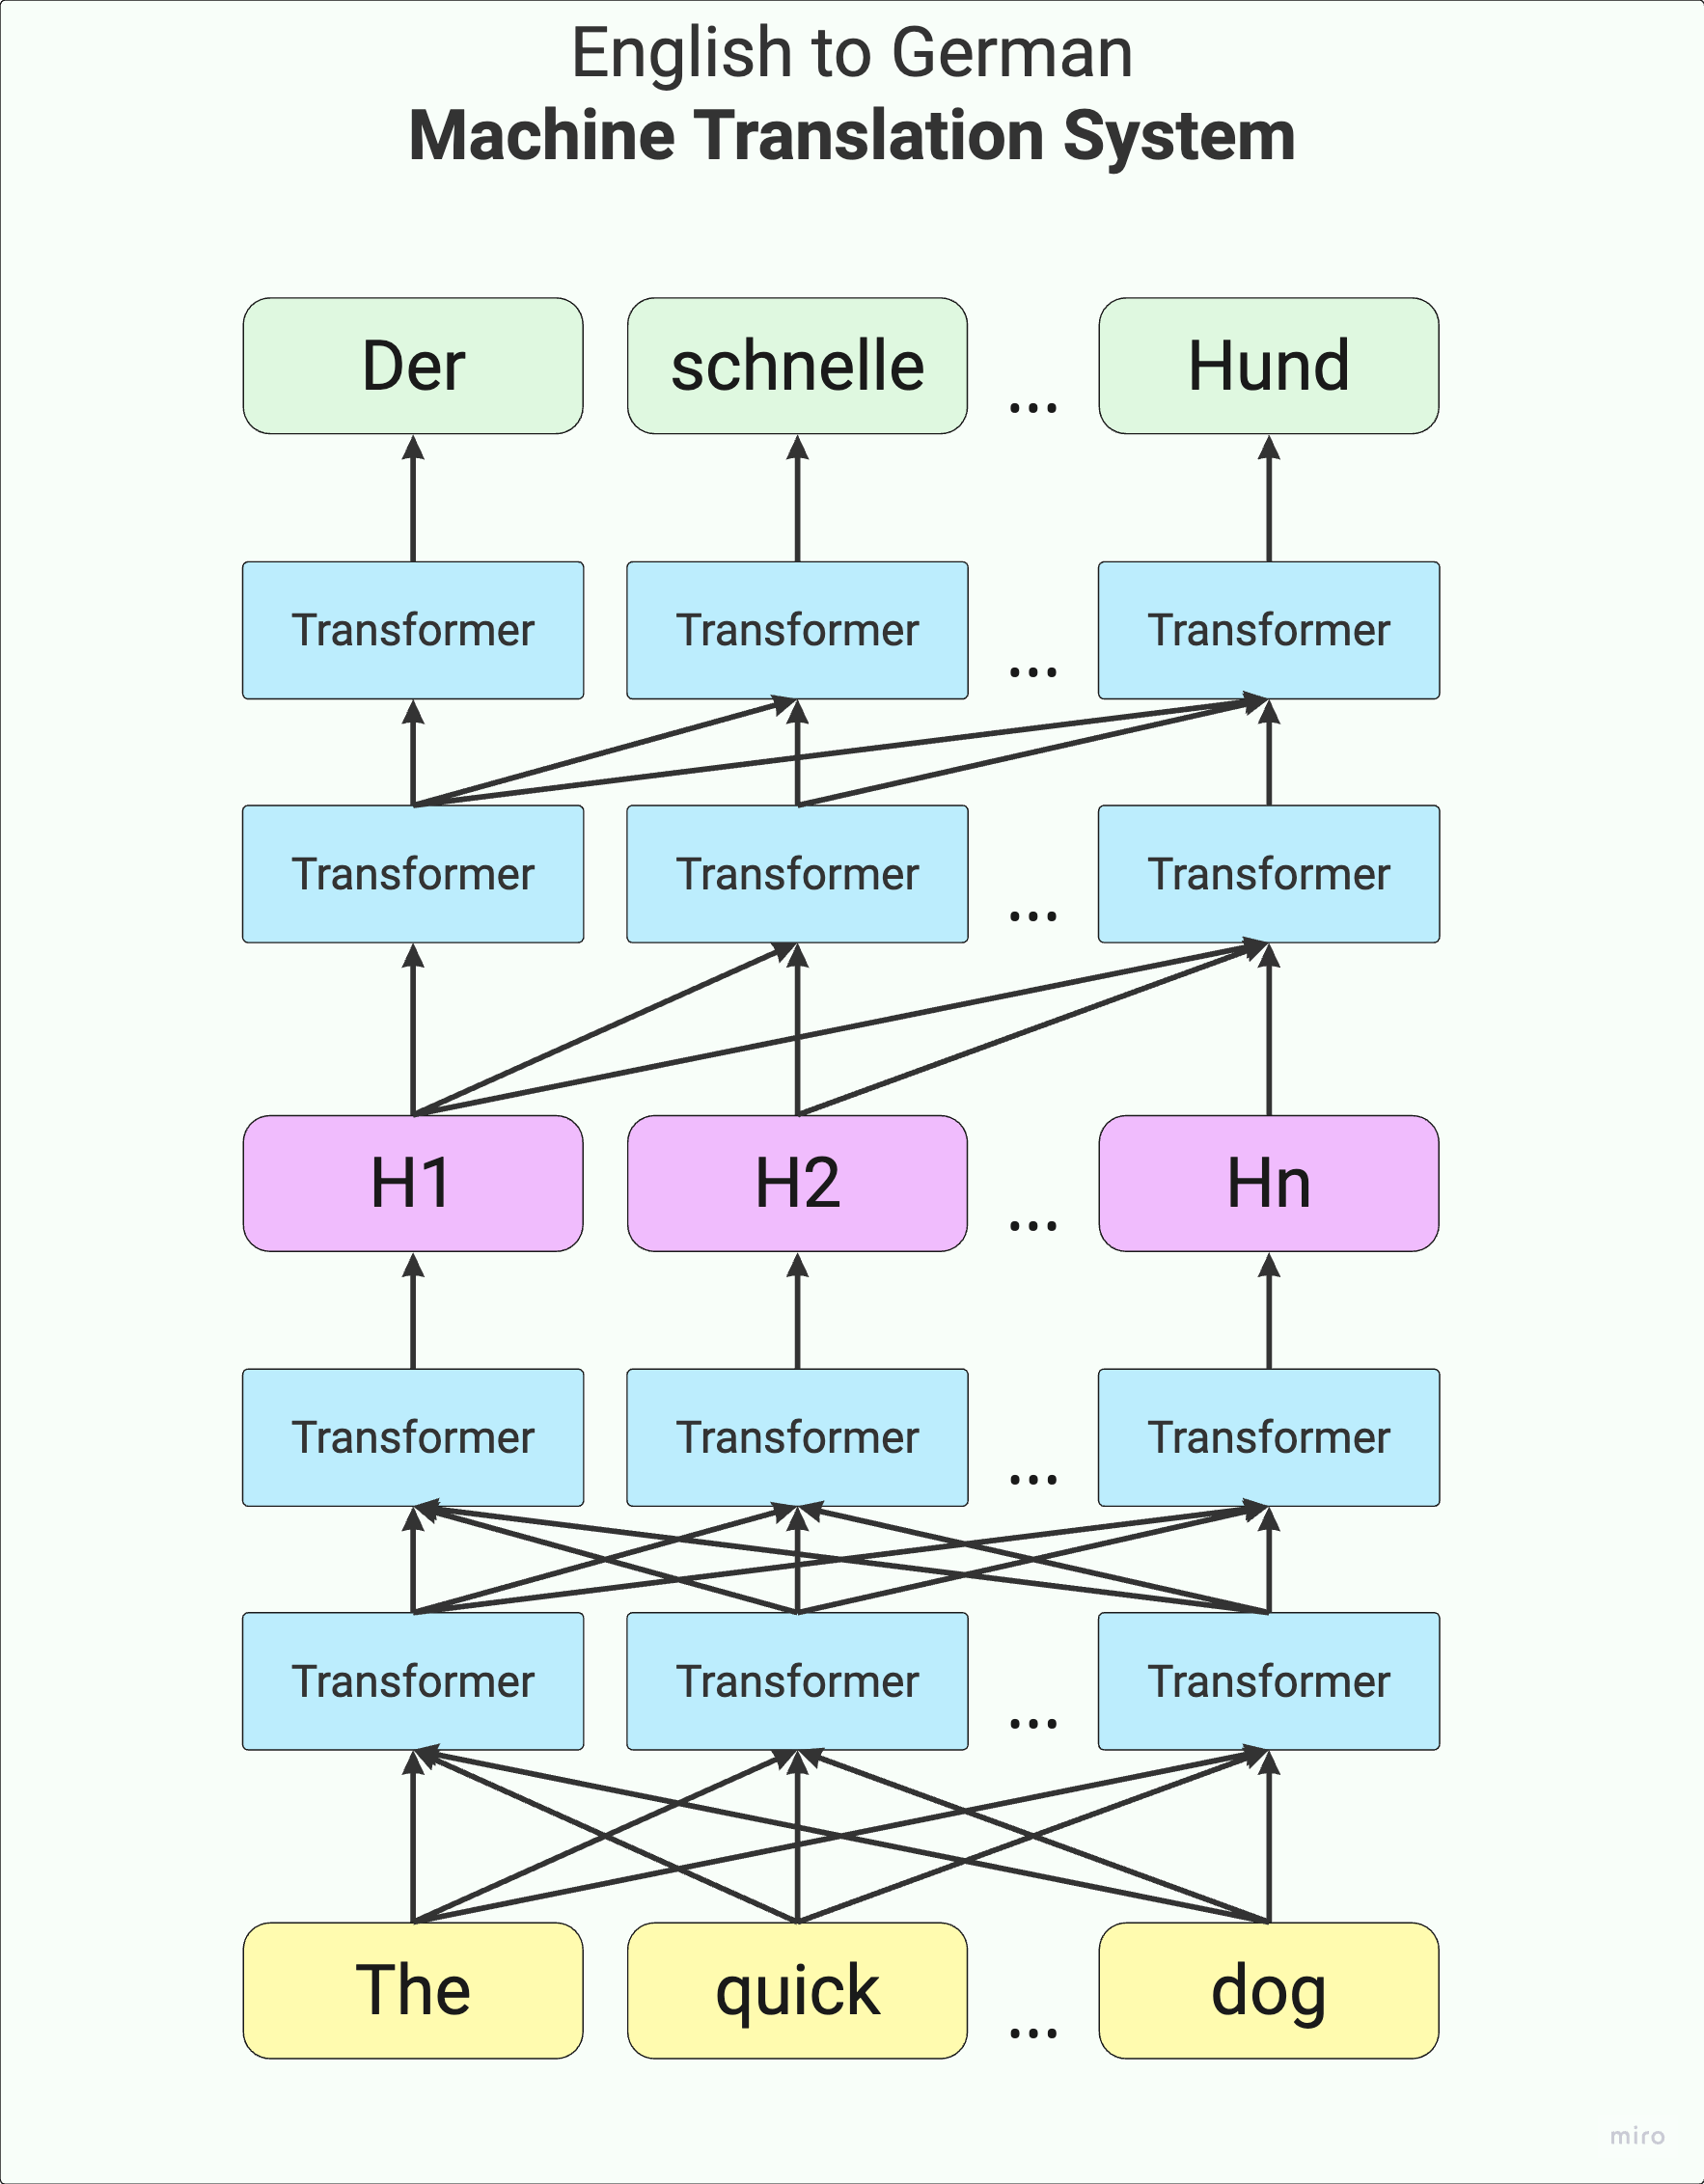

In [ ]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


def get_data_loaders(batch_size, block_size):
    def collate_fn(batch):
        src_texts = [item['eng'] for item in batch]
        trg_texts = [item['deu'] for item in batch]

        src_batch = preprocessor.tokenize_and_pad(src_texts, block_size)
        trg_batch = preprocessor.tokenize_and_pad(trg_texts, block_size)
        bos_tokens = torch.full((trg_batch.shape[0], 1), preprocessor.bos_token_id, dtype=torch.long)
        trg_batch = torch.cat([bos_tokens, trg_batch[:, : -1]], dim=1)

        return src_batch, trg_batch

    # DataLoader
    train_loader = DataLoader(
        dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn
    )
    val_loader = DataLoader(
        dataset['validation'],
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn,
    )

    return train_loader, val_loader

In [ ]:
import math
import numpy
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


class PositionalEncoding(nn.Module):
    def __init__(self, n_emb, max_len=5000):
        super().__init__()
        self.n_emb = n_emb
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, n_emb, 2) * -(math.log(10000.0) / n_emb))
        pe = torch.zeros(max_len, n_emb)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, T):
        return self.pe[:T, :].detach()


class FeedFoward(nn.Module):
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class BidirectionalContextAttentionHead(nn.Module):
    def __init__(self, head_size, n_embd, dropout):
        super().__init__()
        self.n_embd = n_embd
        self.head_size = head_size
        self.dropout = dropout

        self.key = nn.Linear(self.n_embd, self.head_size, bias=False)
        self.query = nn.Linear(self.n_embd, self.head_size, bias=False)
        self.value = nn.Linear(self.n_embd, self.head_size, bias=False)

        self.dropout_layer = nn.Dropout(self.dropout)

    def forward(self, x):
        B, T, E = x.shape

        k = self.key(x)  # (B, T, E)
        q = self.query(x)  # (B, T, E)

        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * self.head_size**-0.5  # (B, T, T)
        wei = F.softmax(
            wei, dim=-1
        )  # (B, T, T)  # softmax over the last dimension to create attention weights
        wei = self.dropout_layer(wei)

        # perform the weighted aggregation of the values
        v = self.value(x)  # (B, T, E)
        out = wei @ v  # (B, T, T) @ (B, T, E) -> (B, T, E)

        return out


class BidirectionalContextMultiHeadAttention(nn.Module):
    def __init__(self, n_head, head_size, n_embd, dropout):
        super().__init__()
        self.n_head = n_head
        self.head_size = head_size
        self.n_embd = n_embd
        self.dropout = dropout

        self.heads = nn.ModuleList(
            [
                BidirectionalContextAttentionHead(
                    self.head_size, self.n_embd, self.dropout
                )
                for _ in range(self.n_head)
            ]
        )
        self.proj = nn.Linear(self.n_embd, self.n_embd)
        self.dropout_layer = nn.Dropout(self.dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout_layer(self.proj(out))
        return out


class EncoderBlock(nn.Module):
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        self.n_embd = n_embd
        self.n_head = n_head
        self.dropout = dropout

        head_size = self.n_embd // self.n_head
        self.sa = BidirectionalContextMultiHeadAttention(
            self.n_head, head_size, self.n_embd, self.dropout
        )
        self.ffwd = FeedFoward(self.n_embd, self.dropout)
        self.ln1 = nn.LayerNorm(self.n_embd)
        self.ln2 = nn.LayerNorm(self.n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class UnidirectionalContextAttentionHead(nn.Module):
    def __init__(self, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.head_size = head_size
        self.n_embd = n_embd
        self.block_size = block_size
        self.dropout = dropout

        self.key = nn.Linear(self.n_embd, self.head_size, bias=False)
        self.query = nn.Linear(self.n_embd, self.head_size, bias=False)
        self.value = nn.Linear(self.n_embd, self.head_size, bias=False)

        self.dropout_layer = nn.Dropout(self.dropout)

    def forward(self, x):
        B, T, E = x.shape
        tril_mask = torch.tril(torch.ones((T, T), device=x.device)).bool()

        k = self.key(x)  # (B, T, E)
        q = self.query(x)  # (B, T, E)

        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * E**-0.5  # (B, T, E) @ (B, E, T) -> (B, T, T)

        # todo - experimental
        wei = wei.masked_fill(~tril_mask, float('-inf'))
        # wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)

        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout_layer(wei)

        # perform the weighted aggregation of the values
        v = self.value(x)  # (B, T, E)
        out = wei @ v  # (B, T, T) @ (B, T, E) -> (B, T, E)

        return out


class UnidirectionalContextMultiHeadAttention(nn.Module):
    def __init__(self, n_head, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.n_head = n_head
        self.head_size = head_size
        self.n_embd = n_embd
        self.block_size = block_size
        self.dropout = dropout

        self.heads = nn.ModuleList(
            [
                UnidirectionalContextAttentionHead(
                    self.head_size, self.n_embd, self.block_size, self.dropout
                )
                for _ in range(self.n_head)
            ]
        )
        self.proj = nn.Linear(self.n_embd, self.n_embd)
        self.dropout_layer = nn.Dropout(self.dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout_layer(self.proj(out))
        return out


class CrossAttentionBidirectionalAttentionHead(nn.Module):
    def __init__(self, head_size, n_embd, dropout):
        super().__init__()
        self.n_embd = n_embd
        self.head_size = head_size
        self.dropout = dropout

        self.key = nn.Linear(self.n_embd, self.head_size, bias=False)
        self.query = nn.Linear(self.n_embd, self.head_size, bias=False)
        self.value = nn.Linear(self.n_embd, self.head_size, bias=False)

        self.dropout_layer = nn.Dropout(self.dropout)

    def forward(self, x, context):
        B, T, E = x.shape

        k = self.key(context)  # (B, T, E)
        q = self.query(x)  # (B, T, E)

        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * self.head_size**-0.5  # (B, T, T)
        wei = F.softmax(
            wei, dim=-1
        )  # (B, T, T)  # softmax over the last dimension to create attention weights
        wei = self.dropout_layer(wei)

        # perform the weighted aggregation of the values
        v = self.value(context)  # (B, T, E)
        out = wei @ v  # (B, T, T) @ (B, T, E) -> (B, T, E)

        return out


class CrossAttentionMultiHead(nn.Module):
    def __init__(self, n_head, head_size, n_embd, dropout):
        super().__init__()
        self.n_head = n_head
        self.head_size = head_size
        self.n_embd = n_embd
        self.dropout = dropout

        # Instantiate multiple heads for cross-attention
        self.heads = nn.ModuleList(
            [
                CrossAttentionBidirectionalAttentionHead(
                    self.head_size, self.n_embd, self.dropout
                )
                for _ in range(self.n_head)
            ]
        )
        self.proj = nn.Linear(self.n_embd, self.n_embd)
        self.dropout_layer = nn.Dropout(self.dropout)

    def forward(self, x, context):
        out = torch.cat([h(x, context) for h in self.heads], dim=-1)
        out = self.dropout_layer(self.proj(out))
        return out


class DecoderBlock(nn.Module):
    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        self.n_embd = n_embd
        self.n_head = n_head
        self.block_size = block_size
        self.dropout = dropout

        head_size = self.n_embd // self.n_head
        self.masked_sa = UnidirectionalContextMultiHeadAttention(
            self.n_head, head_size, self.n_embd, self.block_size, self.dropout
        )
        self.cross_attn = CrossAttentionMultiHead(
            self.n_head, head_size, self.n_embd, self.dropout
        )

        self.ffwd = FeedFoward(self.n_embd, self.dropout)
        self.ln1 = nn.LayerNorm(self.n_embd)
        self.ln2 = nn.LayerNorm(self.n_embd)
        self.ln3 = nn.LayerNorm(self.n_embd)

    def forward(self, x, context):
        x = self.ln1(x + self.masked_sa(x))
        x = self.ln2(x + self.cross_attn(x, context))
        x = self.ln3(x + self.ffwd(x))
        return x


class NMT(nn.Module):
    def __init__(self, vocab_size, n_embd, n_head, n_layer, block_size, dropout):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_embd = n_embd
        self.n_head = n_head
        self.n_layer = n_layer
        self.block_size = block_size
        self.dropout = dropout

        self.shared_embedding = nn.Embedding(self.vocab_size, self.n_embd)
        self.position_embedding_table = PositionalEncoding(self.n_embd)

        self.encoder_blocks = nn.ModuleList(
            [
                EncoderBlock(self.n_embd, self.n_head, self.dropout)
                for _ in range(self.n_layer)
            ]
        )
        self.decoder_blocks = nn.ModuleList(
            [
                DecoderBlock(self.n_embd, self.n_head, self.block_size, self.dropout)
                for _ in range(self.n_layer)
            ]
        )

        self.ln_f = nn.LayerNorm(self.n_embd)
        self.output_layer = nn.Linear(self.n_embd, self.vocab_size)

    def forward(self, input_ids, target_ids):
        B, T = input_ids.shape

        tok_emb = self.shared_embedding(input_ids)
        pos_emb = self.position_embedding_table(input_ids.shape[-1])  # (T,E)
        encoder_output = tok_emb + pos_emb  # (B, T, E)

        # Encode
        for block in self.encoder_blocks:
            encoder_output = block(encoder_output)

        # Decode
        tok_emb = self.shared_embedding(target_ids)
        pos_emb = self.position_embedding_table(target_ids.shape[-1])  # (T, E)
        decoder_output = tok_emb + pos_emb  # (B, T, E)

        for block in self.decoder_blocks:
            decoder_output = block(decoder_output, encoder_output)

        # Output
        logits = self.output_layer(self.ln_f(decoder_output))

        return logits


# Aim UI

In [ ]:
%load_ext aim
!aim init
%aim up

# TASK1: Integrate Aim (experiment tracking tool) in the training loop (5 points)

 **Log**:
  - hparams
  - number of parameters in the model
  - the optimizer name

**Track**:
  - trainig loss
  - validation loss
  - validation BLEU score
  - sample generations on validation set

In [ ]:
import torch.optim as optim

hparams = {
    "vocab_size": len(preprocessor.token_to_id),
    "batch_size": 32,
    "block_size": 32,
    "max_iters": 5000,
    "eval_interval": 100,
    "learning_rate": 1e-3,
    "num_epochs": 1,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu',
    "eval_iters": 200,
    "n_embd": 64,
    "n_head": 4,
    "n_layer": 8,
    "dropout": 0.1,
    "seed": 1337,
}


# Initialize and run a simple test
model = NMT(
    vocab_size=hparams["vocab_size"],
    n_embd=hparams["n_embd"],
    n_head=hparams["n_head"],
    n_layer=hparams["n_layer"],
    block_size=hparams["block_size"],
    dropout=hparams["dropout"],
)
model = model.to(hparams["device"])
# print the number of parameters in the model
num_model_params = sum(p.numel() for p in model.parameters()) / 1e6
print(num_model_params, 'M parameters')


# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=hparams["learning_rate"])
loss_fn = nn.CrossEntropyLoss(
    ignore_index=preprocessor.pad_token_id
)  # Assuming 0 is the pad token index

In [ ]:
## YOUR_CODE_STARTS_HERE

## YOUR_CODE_ENDS_HERE

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import random
from os.path import exists

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction


def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    references = []
    hypotheses = []

    with torch.no_grad():
        for src_batch, trg_batch in tqdm(loader, desc="Evaluating", position=0, leave=True):
            src_batch, trg_batch = src_batch.to(hparams['device']), trg_batch.to(hparams['device'])

            outputs = model(src_batch, trg_batch)
            loss = loss_fn(outputs.view(-1, outputs.size(-1)), trg_batch.view(-1))
            total_loss += loss.item()

            output_sequences = outputs.argmax(dim=-1)
            for i in range(output_sequences.size(0)):
                ref = [
                    preprocessor.id_to_token[word.item()]
                    for word in trg_batch[i].cpu()
                    if word != preprocessor.pad_token_id
                ]
                hyp = [
                    preprocessor.id_to_token[word.item()]
                    for word in output_sequences[i].cpu()
                    if word != preprocessor.pad_token_id
                ]

                references.append([ref])  # BLEU expects a list of references
                hypotheses.append(hyp)

    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=SmoothingFunction().method1)
    return total_loss / len(loader), bleu_score, hypotheses[:5]


# Training function with evaluation calls
def train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn, eval_interval):
    model.train()
    total_loss = 0
    for idx, (src_batch, trg_batch) in enumerate(tqdm(train_loader, desc="Training", leave=True)):
        src_batch, trg_batch = src_batch.to(hparams["device"]), trg_batch.to(hparams["device"])

        optimizer.zero_grad()
        output = model(src_batch, trg_batch)
        loss = loss_fn(output.view(-1, output.size(-1)), trg_batch.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Evaluate every eval_interval iterations
        if (idx + 1) % eval_interval == 0:
            val_loss, val_bleu_score, eval_sample_generations = evaluate(
                model, val_loader, loss_fn
            )
            print(f"\nIteration {idx + 1}:\n     Train Loss = {loss.item():.4f}, Val Loss = {val_loss:.4f}, Val BLEU = {val_bleu_score:.4f}\n")
            print(f"\nSample generation: '{' '.join(eval_sample_generations[0])}'\n")

            ## YOUR_CODE_STARTS_HERE

            ## YOUR_CODE_ENDS_HERE

            for eval_sample_generation in eval_sample_generations:
                ## YOUR_CODE_STARTS_HERE

                ## YOUR_CODE_ENDS_HERE

            model.train()
            # Save the model
            os.makedirs("ckpts", exist_ok=True)
            torch.save(model.state_dict(), f"./ckpts/translation_model_{idx}.pth")

    return total_loss / len(train_loader)


train_loader, val_loader = get_data_loaders(hparams["batch_size"], hparams["block_size"])

# Training loop
for epoch in range(hparams["num_epochs"]):
    epoch_loss = train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn, hparams['eval_interval'])
    print(f"Epoch {epoch+1}/{hparams['num_epochs']}, Epoch Loss: {epoch_loss:.4f}")

# TASK2: Run the experiment in Task1 with varying *batch sizes* and *learning rates*, and analyze their impact on loss and BLEU scores. Write the report in a single text cell in the end (15 points)

In [ ]:
## YOUR_CODE_STARTS_HERE

## YOUR_CODE_ENDS_HERE